In [11]:
%load_ext Cython
%load_ext line_profiler

## prepare data


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May  5 22:05:14 2018

@author: sunan
"""
import time
import scipy.sparse as sp
import numpy as np
from implicit_mf import *
import matplotlib.pyplot as plt

sample_matrix = sp.load_npz('sample_matrix.npz')

sample_array = sample_matrix.toarray()
#Take a look at the sample sparsity
sparsity = float(len(sample_array.nonzero()[0]))
sparsity /= (sample_array.shape[0] * sample_array.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

def train_test_split(data):
    #data should be ndarray format
    test = np.zeros(data.shape)
    train = data.copy()
    for user in range(data.shape[0]):
        test_index = np.random.choice(data[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_index] = 0.
        test[user, test_index] = data[user, test_index]
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

train_array, test_array = train_test_split(sample_array)
train = sp.csr_matrix(train_array)
test = sp.csr_matrix(test_array)


Sparsity: 3.63%


## Original version of matrix factorization method

We measure the time of training process and evaluation process seperately. For the training process, we only measure 1 iteration time to be efficient.

In [49]:
import time
from scipy.sparse.linalg import spsolve
import numpy as np
import scipy.sparse as sp


class ImplicitMF():

    def __init__(self, counts, alpha, num_factors=40, num_iterations=30,
                 reg_param=0.8):
        self.counts = counts
        self.alpha = alpha
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def fit(self):
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))
        scores = []
        for i in range(self.num_iterations):
            t0 = time.time()
            print ('Solving for user vectors...')
            self.user_vectors = self.iteration(True, sp.csr_matrix(self.item_vectors))
            print ('Solving for item vectors...')
            self.item_vectors = self.iteration(False, sp.csr_matrix(self.user_vectors))
            t1 = time.time()
            print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
            
            scores.append(mf.evaluate(train))
            
        return t1 - t0, scores
    
    def iteration(self, user, fixed_vecs):
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        YTY = fixed_vecs.T.dot(fixed_vecs)
        eye = sp.eye(num_fixed)
        lambda_eye = self.reg_param * sp.eye(self.num_factors)
        solve_vecs = np.zeros((num_solve, self.num_factors))

        t = time.time()
        for i in range(num_solve):
            if user:
                counts_i = self.counts[i].toarray()
            else:
                counts_i = self.counts[:, i].T.toarray()
            CuI = sp.diags(1 + self.alpha * counts_i, [0])
            pu = counts_i.copy()
            pu[np.where(pu != 0)] = 1.0
            YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
            YTCupu = fixed_vecs.T.dot(CuI + eye).dot(sp.csr_matrix(pu).T)
            xu = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)
            solve_vecs[i] = xu
            if i % 1000 == 0:
                print ('Solved %i vecs in %d seconds' % (i, time.time() - t))
                t = time.time()

        return solve_vecs
    
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vectors[u, :].dot(self.item_vectors[i, :].T)
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vectors.shape[0],self.item_vectors.shape[0]))
        for u in range(self.user_vectors.shape[0]):
            for i in range(self.item_vectors.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
    
    def ranking(self, predictions):
        temp = predictions.argsort(axis = 1)
        #produce the abosulte ranks for each item for each user
        pred_ranks = np.empty_like(temp)
        for i in range(self.num_users):
            pred_ranks[i,temp[i,:]] = np.arange(self.num_items - 1, -1, -1)
        #convert the ranks to rank percentile
        pred_ranks_percentile = pred_ranks / np.max(pred_ranks) * 100
        return pred_ranks_percentile
    
    def evaluate(self, test):
        predictions = self.predict_all()
        pred_ranks = self.ranking(predictions)
        test = test.todense()
        metrics = np.sum(np.multiply(test, pred_ranks))/np.sum(test)
        return metrics


#### Original MF fitting time

In [4]:
mf = ImplicitMF(train, alpha=1, num_factors=40, num_iterations=1, reg_param=0.1)
t, scores_mf = mf.fit()

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 25 seconds
Solved 2000 vecs in 26 seconds
Solved 3000 vecs in 24 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 12 seconds
Solved 2000 vecs in 12 seconds
Solved 3000 vecs in 13 seconds
Solved 4000 vecs in 13 seconds
Solved 5000 vecs in 13 seconds
Solved 6000 vecs in 12 seconds
Solved 7000 vecs in 13 seconds
iteration 1 finished in 173.564692 seconds


#### Orignal MF evluation time

In [5]:
import time
start_time = time.time()
score = mf.evaluate(test)
print('evaluation time: ', time.time()-start_time)

evaluation time:  35.01043105125427


#### Record training score (for plot comparison purpose)

In [50]:
mf = ImplicitMF(train, alpha=1, num_factors=40, num_iterations=20, reg_param=0.1)

In [51]:
t, scores_mf = mf.fit()

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 25 seconds
Solved 2000 vecs in 24 seconds
Solved 3000 vecs in 25 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 12 seconds
Solved 2000 vecs in 12 seconds
Solved 3000 vecs in 12 seconds
Solved 4000 vecs in 12 seconds
Solved 5000 vecs in 13 seconds
Solved 6000 vecs in 13 seconds
Solved 7000 vecs in 13 seconds
iteration 1 finished in 172.753930 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 24 seconds
Solved 2000 vecs in 25 seconds
Solved 3000 vecs in 25 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 13 seconds
Solved 2000 vecs in 13 seconds
Solved 3000 vecs in 12 seconds
Solved 4000 vecs in 13 seconds
Solved 5000 vecs in 12 seconds
Solved 6000 vecs in 12 seconds
Solved 7000 vecs in 12 seconds
iteration 2 finished in 171.720167 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in

Solved 5000 vecs in 12 seconds
Solved 6000 vecs in 12 seconds
Solved 7000 vecs in 12 seconds
iteration 18 finished in 173.966869 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 25 seconds
Solved 2000 vecs in 25 seconds
Solved 3000 vecs in 25 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 13 seconds
Solved 2000 vecs in 12 seconds
Solved 3000 vecs in 12 seconds
Solved 4000 vecs in 12 seconds
Solved 5000 vecs in 12 seconds
Solved 6000 vecs in 12 seconds
Solved 7000 vecs in 12 seconds
iteration 19 finished in 173.947393 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 25 seconds
Solved 2000 vecs in 25 seconds
Solved 3000 vecs in 25 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 12 seconds
Solved 2000 vecs in 13 seconds
Solved 3000 vecs in 12 seconds
Solved 4000 vecs in 12 seconds
Solved 5000 vecs in 12 seconds
Solved 6000 vecs in 12 seconds
Solved 700

#### Calculate time per iteration for each num_factors (for plot comparison purpose)

In [30]:
factors = [20, 40, 60, 80]
ts1 = []
for factor in factors:
    mf = ImplicitMF(train, alpha=1, num_factors=factor, num_iterations=1, reg_param=0.1)
    t, scores_mf = mf.fit()
    ts1.append(t)
print(ts1)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 8 seconds
Solved 2000 vecs in 8 seconds
Solved 3000 vecs in 8 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 5 seconds
Solved 2000 vecs in 5 seconds
Solved 3000 vecs in 5 seconds
Solved 4000 vecs in 5 seconds
Solved 5000 vecs in 5 seconds
Solved 6000 vecs in 5 seconds
Solved 7000 vecs in 5 seconds
iteration 1 finished in 68.475078 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 23 seconds
Solved 2000 vecs in 23 seconds
Solved 3000 vecs in 23 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 12 seconds
Solved 2000 vecs in 12 seconds
Solved 3000 vecs in 12 seconds
Solved 4000 vecs in 14 seconds
Solved 5000 vecs in 13 seconds
Solved 6000 vecs in 12 seconds
Solved 7000 vecs in 12 seconds
iteration 1 finished in 166.785937 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 47 seconds

## First change - Conjugate Gradient method
Here we are using the approach outlined in [paper](https://www.semanticscholar.org/paper/Applications-of-the-conjugate-gradient-method-for-Tak%C3%A1cs-Pil%C3%A1szy/46e905e9134e97c625ea6c8f6fa961b0b4c80fcf)

In [31]:
import time
from scipy.sparse.linalg import spsolve
import numpy as np
import scipy.sparse as sp


class ImplicitMF():

    def __init__(self, counts, alpha, num_factors=40, num_iterations=30,
                 reg_param=0.8):
        self.counts = counts
        self.alpha = alpha
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def fit(self):
        # X
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        # Y
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))
        
        for i in range(self.num_iterations):
            t0 = time.time()
            print ('Solving for user vectors...')
            self.user_vectors = self.iteration(True, self.item_vectors)
            print ('Solving for item vectors...')
            self.item_vectors = self.iteration(False, self.user_vectors)
            t1 = time.time()
            print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
        return t1-t0

    def nonzeros(self, m, row):
        for index in range(m.indptr[row], m.indptr[row+1]):
            yield m.indices[index], m.data[index]


    def iteration(self, user, fixed_vecs):
        
        #    x_u = ((Y.T*Y + Y.T*(Cu - I) * Y) + lambda*I)^-1 * (X.T * Cu * p(u))
        #    y_i = ((X.T*X + X.T*(Ci - I) * X) + lambda*I)^-1 * (Y.T * Ci * p(i))
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        if user:
            Cui = (self.counts * self.alpha).tocsr()
        else:
            Cui = (self.counts.T * self.alpha).tocsr()

        YtY = fixed_vecs.T.dot(fixed_vecs) + self.reg_param * np.eye(self.num_factors)
        # 40*40
        solve_vecs = np.zeros((num_solve, self.num_factors))
        t = time.time()
        for i in range(num_solve):
            if user:
                x = self.user_vectors[i]
            else:
                x = self.item_vectors[i]
            r = -YtY.dot(x)
            for j, confidence in self.nonzeros(Cui, i):
                r += (confidence - (confidence - 1) * fixed_vecs[j].dot(x)) * fixed_vecs[j]
            p = r.copy()
            
            rsold = r.dot(r.T)
            for it in range(3):
                Ap = p.dot(YtY)
                pt = p.T
                for j, confidence in self.nonzeros(Cui, i):
                    Ap += (confidence - 1) * fixed_vecs[j].dot(pt) * fixed_vecs[j]
                alpha = rsold / p.dot(Ap.T)

                x += alpha * p
                r -= alpha * Ap
                
                rsnew = r.dot(r.T)
                p = r + (rsnew/rsold) * p
                rsold = rsnew
            solve_vecs[i] = x
            

            if i % 1000 == 0:
                print ('Solved %i vecs in %d seconds' % (i, time.time() - t))
                t = time.time()

        return solve_vecs
    
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vectors[u, :].dot(self.item_vectors[i, :].T)
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vectors.shape[0],self.item_vectors.shape[0]))
        for u in range(self.user_vectors.shape[0]):
            for i in range(self.item_vectors.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
    
    def ranking(self, predictions):
        temp = predictions.argsort(axis = 1)
        #produce the abosulte ranks for each item for each user
        pred_ranks = np.empty_like(temp)
        for i in range(self.num_users):
            pred_ranks[i,temp[i,:]] = np.arange(self.num_items - 1, -1, -1)
        #convert the ranks to rank percentile
        pred_ranks_percentile = pred_ranks / np.max(pred_ranks) * 100
        return pred_ranks_percentile
    
    def evaluate(self, test):
        predictions = self.predict_all()
        pred_ranks = self.ranking(predictions)
        test = test.todense()
        metrics = np.sum(np.multiply(test, pred_ranks))/np.sum(test)
        return metrics
    

MF fitting time after first change

In [7]:
mf = ImplicitMF(train, alpha=1, num_factors=40, num_iterations=1, reg_param=0.1)
t = mf.fit()

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 10 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 4 seconds
Solved 5000 vecs in 4 seconds
Solved 6000 vecs in 4 seconds
Solved 7000 vecs in 4 seconds
iteration 1 finished in 62.584715 seconds


#### Calculate time per iteration for each num_factors (for plot comparison purpose)

In [32]:
ts2 = []
for factor in factors:
    mf = ImplicitMF(train, alpha=1, num_factors=factor, num_iterations=1, reg_param=0.1)
    t = mf.fit()
    ts2.append(t)
print(ts2)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 10 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 9 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 5 seconds
Solved 5000 vecs in 4 seconds
Solved 6000 vecs in 4 seconds
Solved 7000 vecs in 4 seconds
iteration 1 finished in 63.504553 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 9 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solved 4000 vecs in 4 seconds
Solved 5000 vecs in 4 seconds
Solved 6000 vecs in 4 seconds
Solved 7000 vecs in 4 seconds
iteration 1 finished in 62.633749 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 200

## Second change - Python performance tips change, still cg method

In [33]:
import time
from scipy.sparse.linalg import spsolve
import numpy as np
import scipy.sparse as sp


class ImplicitMF():

    def __init__(self, Cui, num_factors=40, num_iterations=30,
                 reg_param=0.8):
        self.Cui = Cui
        self.num_users = Cui.shape[0]
        self.num_items = Cui.shape[1]
        self.num_factors = num_factors
        self.num_iterations = num_iterations
        self.reg_param = reg_param

    def fit(self):
        Cui, Ciu = self.Cui.tocsr(), self.Cui.T.tocsr()

        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))
        
        for i in range(self.num_iterations):
            t0 = time.time()
            print ('Solving for user vectors...')
            self.user_vectors = self.iteration(Cui, self.user_vectors, self.item_vectors)
            print ('Solving for item vectors...')
            self.item_vectors = self.iteration(Ciu, self.user_vectors, self.item_vectors)
            t1 = time.time()
            print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
        return t1-t0

    def nonzeros(self, m, row):
        for index in range(m.indptr[row], m.indptr[row+1]):
            yield m.indices[index], m.data[index]


    def iteration(self, Cui, user_vectors, fixed_vecs):
        
        num_solve = user_vectors.shape[0]

        YtY = fixed_vecs.T.dot(fixed_vecs) + self.reg_param * np.eye(self.num_factors)

        solve_vecs = np.zeros((num_solve, self.num_factors))
        t = time.time()
        
        for i in range(num_solve):
            x = self.user_vectors[i]

            r = -YtY.dot(x)
            for j, confidence in self.nonzeros(Cui, i):
                r += (confidence - (confidence - 1) * fixed_vecs[j].dot(x)) * fixed_vecs[j]
            p = r.copy()
            
            rsold = r.dot(r.T)
            for it in range(3):
                Ap = p.dot(YtY)
                pt = p.T
                for j, confidence in self.nonzeros(Cui, i):
                    Ap += (confidence - 1) * fixed_vecs[j].dot(pt) * fixed_vecs[j]
                alpha = rsold / p.dot(Ap.T)

                x += alpha * p
                r -= alpha * Ap
                
                rsnew = r.dot(r.T)
                p = r + (rsnew/rsold) * p
                rsold = rsnew
            solve_vecs[i] = x
            

            if i % 1000 == 0:
                print ('Solved %i vecs in %d seconds' % (i, time.time() - t))
                t = time.time()
                
        return solve_vecs
    
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vectors[u, :].dot(self.item_vectors[i, :].T)
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vectors.shape[0],self.item_vectors.shape[0]))
        for u in range(self.user_vectors.shape[0]):
            for i in range(self.item_vectors.shape[0]):
                predictions[u, i] = self.predict(u, i)
        return predictions
    
    def ranking(self, predictions):
        temp = predictions.argsort(axis = 1)
        #produce the abosulte ranks for each item for each user
        pred_ranks = np.empty_like(temp)
        for i in range(self.num_users):
            pred_ranks[i,temp[i,:]] = np.arange(self.num_items - 1, -1, -1)
        #convert the ranks to rank percentile
        pred_ranks_percentile = pred_ranks / np.max(pred_ranks) * 100
        return pred_ranks_percentile
    
    def evaluate(self, test):
        predictions = self.predict_all()
        pred_ranks = self.ranking(predictions)
        test = test.todense()
        metrics = np.sum(np.multiply(test, pred_ranks))/np.sum(test)
        return metrics
    

Here we make a little change on data to fit our new version of MF.

In [9]:
alpha = 1
train = sp.csr_matrix(train_array) * alpha

MF fitting time after second change

In [10]:
mf = ImplicitMF(train, num_factors=40, num_iterations=1, reg_param=0.1)
t = mf.fit()

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 10 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
iteration 1 finished in 45.365681 seconds


#### Calculate time per iteration for each num_factors (for plot comparison purpose)

In [34]:
ts3 = []
for factor in factors:
    mf = ImplicitMF(train, num_factors=factor, num_iterations=1, reg_param=0.1)
    t = mf.fit()
    ts3.append(t)
print(ts3)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 9 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
iteration 1 finished in 42.516318 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 9 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 3 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
iteration 1 finished in 42.312274 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 9 seconds
Solved 2000 vecs in 9 seconds
Solved 3000 vecs in 9 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
iteration 1 finished in 42.425154 seconds
Solv

## Final change - Cythonize, optimize evaluation function

In [62]:
%%cython

cimport numpy as np
import time
from scipy.sparse.linalg import spsolve
import numpy as np
import scipy.sparse as sp
#cimport ctypes
# from cython.parallel import prange



def fit(Cui, int num_factors=40, int num_iterations=20, float reg_param=0.8):
    num_users, num_items = Cui.shape
    
    user_vectors = np.random.normal(size=(num_users, num_factors))
    item_vectors = np.random.normal(size=(num_items, num_factors))
    
    Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()
    scores = []
    for i in range(num_iterations):
        t0 = time.time()
        print ('Solving for user vectors...')
        user_vectors = iteration(Cui.indptr, Cui.indices, Cui.data.astype('float32'), user_vectors, item_vectors, reg_param)
        print ('Solving for item vectors...')
        item_vectors = iteration(Ciu.indptr, Ciu.indices, Ciu.data.astype('float32'), item_vectors, user_vectors, reg_param)
        t1 = time.time()
        print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))
        scores.append(evaluate(user_vectors, item_vectors, Cui))
    return user_vectors, item_vectors, t1-t0, scores

#     def nonzeros(self, int[:,:] m, int row):
def nonzeros(indptr, indices, data, row):
    cdef int index
#     for index in range(m.indptr[row], m.indptr[row+1]):
#         yield m.indices[index], m.data[index]
    for index in range(indptr[row], indptr[row+1]):
        yield indices[index], data[index]

def iteration(np.ndarray[int, ndim=1] indptr, np.ndarray[int, ndim=1] indices, np.ndarray[float, ndim=1] data, np.ndarray[double, ndim=2] user_vectors, np.ndarray[double, ndim=2] fixed_vecs, float reg_param):
#         cdef np.ndarray[int, ndim=2] Cui
#         cdef int num_solve = self.num_users if user else self.num_items
#         cdef int num_fixed = fixed_vecs.shape[0]
#         cdef int i, it 


    cdef int num_solve = user_vectors.shape[0]
    cdef int num_factors = user_vectors.shape[1]

    cdef int i, it, j
    cdef float confidence, alpha, rsnew, rsold
    
    cdef np.ndarray[double, ndim=2] YtY = fixed_vecs.T.dot(fixed_vecs) + reg_param * np.eye(num_factors)
    cdef np.ndarray[double, ndim=2] solve_vecs = np.zeros((num_solve, num_factors))
    cdef np.ndarray[double, ndim=1] x, p, r, Ap
    
    t = time.time()
    for i in range(num_solve):
        x = user_vectors[i]
        r = -YtY.dot(x)
        for j, confidence in nonzeros(indptr, indices, data, i):
            r += (confidence - (confidence - 1) * fixed_vecs[j].dot(x)) * fixed_vecs[j]
        p = r.copy()

        rsold = r.dot(r.T)
        for it in range(3):
            Ap = p.dot(YtY)
            pt = p.T
            for j, confidence in nonzeros(indptr, indices, data, i):
                Ap += (confidence - 1) * fixed_vecs[j].dot(pt) * fixed_vecs[j]
            alpha = rsold / p.dot(Ap.T)

            x += alpha * p
            r -= alpha * Ap

            rsnew = r.dot(r.T)
            p = r + (rsnew/rsold) * p
            rsold = rsnew
        solve_vecs[i] = x


        if i % 1000 == 0:
            print ('Solved %i vecs in %d seconds' % (i, time.time() - t))
            t = time.time()

    return solve_vecs


def ranking(num_users, num_items, predictions):
    temp = predictions.argsort(axis = 1)
    #produce the abosulte ranks for each item for each user
    pred_ranks = np.empty_like(temp)
    for i in range(num_users):
        pred_ranks[i,temp[i,:]] = np.arange(num_items - 1, -1, -1)
    #convert the ranks to rank percentile
    pred_ranks_percentile = pred_ranks / np.max(pred_ranks) * 100
    return pred_ranks_percentile

def evaluate(user_vectors, item_vectors, test):
    #predictions = predict_all(user_vectors, item_vectors)
    predictions = user_vectors.dot(item_vectors.T)
    num_users = user_vectors.shape[0]
    num_items = item_vectors.shape[0]
    pred_ranks = ranking(num_users, num_items, predictions)
    test = test.todense()
    metrics = np.sum(np.multiply(test, pred_ranks))/np.sum(test)
    return metrics


MF fitting time after final change

In [25]:
user_vectors, item_vectors, t, scores = fit(train, num_factors=40, num_iterations=1, reg_param=0.1)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 2 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 2 seconds
iteration 1 finished in 28.956326 seconds


#### Final evaluation time (10 times faster)

In [14]:
import time
start_time = time.time()
score = evaluate(user_vectors, item_vectors, test)
print('evaluation time: ', time.time()-start_time)
print('score is', score)

evaluation time:  2.921937942504883
score is 22.766999566177684


#### Record training score (for plot comparison purpose)

In [63]:
user_vectors, item_vectors, t, scores_cg = fit(train, num_factors=40, num_iterations=20, reg_param=0.1)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 2 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 2 seconds
Solved 7000 vecs in 2 seconds
iteration 1 finished in 29.179330 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 2 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 2 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 2 seconds
iteration 2 finished in 28.413969 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000

Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 2 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 2 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 2 seconds
iteration 19 finished in 29.217005 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 2 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 2 seconds
Solved 7000 vecs in 2 seconds
iteration 20 finished in 29.161140 seconds


#### Calculate time per iteration for each num_factors (for plot comparison purpose)

In [28]:
ts4 = []
for factor in factors:
    user_vectors, item_vectors, t, scores = fit(train, num_factors=factor, num_iterations=1, reg_param=0.1)
    ts4.append(t)
print(ts4)

Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 2 seconds
Solved 2000 vecs in 2 seconds
Solved 3000 vecs in 2 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 2 seconds
iteration 1 finished in 29.644476 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000 vecs in 4 seconds
Solved 3000 vecs in 4 seconds
Solving for item vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 1 seconds
Solved 2000 vecs in 1 seconds
Solved 3000 vecs in 1 seconds
Solved 4000 vecs in 2 seconds
Solved 5000 vecs in 1 seconds
Solved 6000 vecs in 1 seconds
Solved 7000 vecs in 2 seconds
iteration 1 finished in 28.076653 seconds
Solving for user vectors...
Solved 0 vecs in 0 seconds
Solved 1000 vecs in 4 seconds
Solved 2000

## Plot comparison

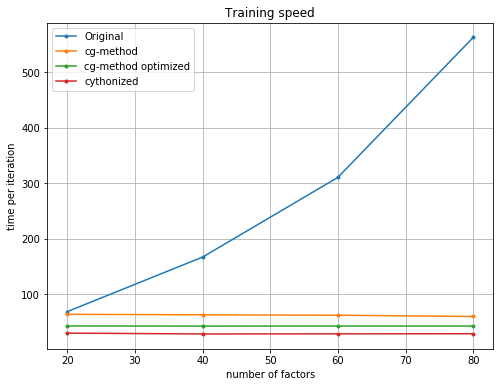

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6

plt.plot(factors, ts1, label = 'Original', marker='.')
plt.plot(factors, ts2, label = 'cg-method', marker='.')
plt.plot(factors, ts3, label = 'cg-method optimized', marker='.')
plt.plot(factors, ts4, label = 'cythonized', marker='.')
plt.xlabel('number of factors')
plt.ylabel('time per iteration')
plt.title('Training speed')
plt.grid(True)
plt.legend()

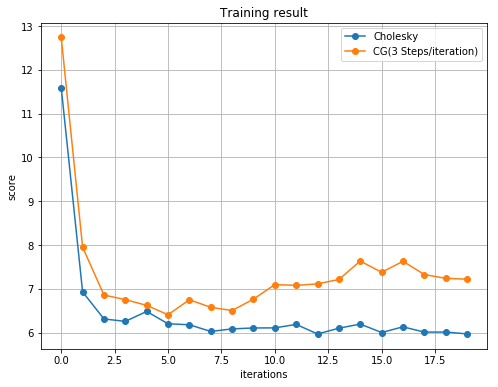

In [64]:
plt.plot(scores_mf, label = 'Cholesky', marker='o')
plt.plot(scores_cg, label = 'CG(3 Steps/iteration)', marker='o')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Training result')
plt.grid(True)
plt.legend()

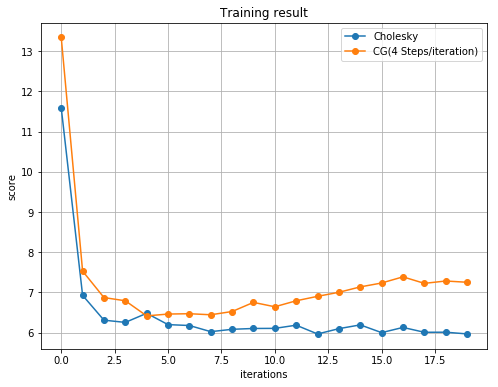

In [58]:
plt.plot(scores_mf, label = 'Cholesky', marker='o')
plt.plot(scores_cg, label = 'CG(4 Steps/iteration)', marker='o')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Training result')
plt.grid(True)
plt.legend()